In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, Flatten, Input, Lambda, LSTM, MaxPooling2D, Reshape
from tensorflow.keras import backend as K
import tensorflow as tf

/home/sergeyk/.local/share/virtualenvs/fsdl-text-recognizer-6Tfq_pVK/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [60]:
DATA_DIRNAME = Path('/home/sergeyk/work/iamdb')

crop_filenames = sorted(list((DATA_DIRNAME / 'forms-cropped').glob('*.jpg')))
gt_filenames = sorted(list((DATA_DIRNAME / 'forms-cropped-gt').glob('*.png')))

NUM_LABELS = 3

X = []
Y = []
for crop_filename in crop_filenames:
    name = crop_filename.stem
    image = cv2.imread(str(crop_filename), cv2.IMREAD_GRAYSCALE)
    
    gt_filename = DATA_DIRNAME / 'forms-cropped-gt' / f'{name}.png'
    gt_image = cv2.imread(str(gt_filename), cv2.IMREAD_GRAYSCALE)
    
    for value in np.unique(gt_image):
        gt_image[gt_image == (value + 1)] = value % 2 + 1
        
    gt_sequence = np.median(gt_image, axis=1)
    
    
    X.append(np.expand_dims(image / 255, -1))
    Y.append(to_categorical(gt_sequence, NUM_LABELS))
    
X = np.array(X).astype(np.float32)
Y = np.array(Y).astype(np.uint8)
print(X.shape, X.dtype, Y.shape, Y.dtype)

(1537, 633, 620, 1) float32 (1537, 633, 3) uint8


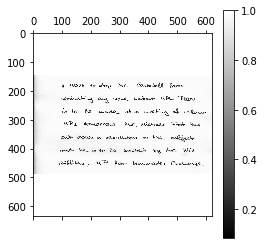

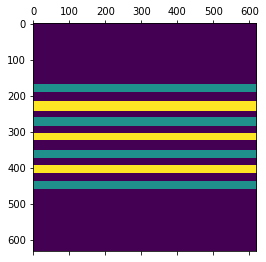

In [104]:
MAX_HEIGHT, MAX_WIDTH, _ = X[0].shape

plt.matshow(X[0].squeeze(), cmap='gray')
plt.colorbar()

plt.matshow(np.repeat(np.expand_dims(Y[0].argmax(-1), -1), MAX_WIDTH, axis=-1))

In [108]:
# For overfitting
X_single = X[0:1]
Y_single = Y[0:1]

# For training
X_train = X[:1000]
Y_train = Y[:1000]
X_test = X[1000:]
Y_test = Y[1000:]

In [127]:
from tensorflow.keras.layers import CuLSTM, TimeDistributed

input_image = Input((MAX_HEIGHT, MAX_WIDTH, 1))

conv = Conv2D(32, kernel_size=(3, 3), strides=(1, 3), activation='relu', padding='same')(input_image)
conv = Conv2D(32, kernel_size=(3, 3), strides=(1, 3), activation='relu', padding='same')(conv)
conv = Conv2D(32, kernel_size=(3, 3), strides=(1, 3), activation='relu', padding='same')(conv)
conv = Conv2D(32, kernel_size=(3, 3), strides=(1, 3), activation='relu', padding='same')(conv)
conv = Conv2D(32, kernel_size=(8, 8), strides=(1, 3), activation='relu', padding='same')(conv)
# conv = Lambda(lambda x: x[:, :, 1:2, :])(conv)
# pred = Conv2D(32, kernel_size=(1, 1), activation='softmax', padding='same')(conv)
# pred = Lambda(lambda x: K.squeeze(x, axis=2))(pred)

lstm_input = Reshape((MAX_HEIGHT, 3 * 32))(conv)
lstm = LSTM(32, return_sequences=True, unroll=True)(lstm_input)
pred = TimeDistributed(Dense(NUM_LABELS, activation='softmax'))(lstm)

model = Model(inputs=input_image, outputs=pred)
model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_83 (InputLayer)        (None, 633, 620, 1)       0         
_________________________________________________________________
conv2d_451 (Conv2D)          (None, 633, 207, 32)      320       
_________________________________________________________________
conv2d_452 (Conv2D)          (None, 633, 69, 32)       9248      
_________________________________________________________________
conv2d_453 (Conv2D)          (None, 633, 23, 32)       9248      
_________________________________________________________________
conv2d_454 (Conv2D)          (None, 633, 8, 32)        9248      
_________________________________________________________________
conv2d_455 (Conv2D)          (None, 633, 3, 32)        65568     
_________________________________________________________________
reshape_20 (Reshape)         (None, 633, 96)           0         
__________

In [128]:
# Overfit

history = model.fit(
    x=X_single, y=Y_single,
    epochs=5,
    steps_per_epoch=100
)

Epoch 1/5


KeyboardInterrupt: 

In [115]:
# Real training
callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5)
]
history = model.fit(
    x=X_train, y=Y_train,
    epochs=40,
    batch_size=32,
    validation_data=(X_test, Y_test),
    callbacks=callbacks
)

Train on 1000 samples, validate on 537 samples
Epoch 1/40
1000/1000 [==============================] - 7s 7ms/step - loss: 0.9527 - categorical_accuracy: 0.5951 - val_loss: 0.9122 - val_categorical_accuracy: 0.6058
Epoch 2/40
1000/1000 [==============================] - 5s 5ms/step - loss: 0.8641 - categorical_accuracy: 0.6330 - val_loss: 0.7282 - val_categorical_accuracy: 0.6935
Epoch 3/40
1000/1000 [==============================] - 5s 5ms/step - loss: 0.7837 - categorical_accuracy: 0.6756 - val_loss: 0.7903 - val_categorical_accuracy: 0.6583
Epoch 4/40
1000/1000 [==============================] - 5s 5ms/step - loss: 0.7920 - categorical_accuracy: 0.6992 - val_loss: 0.9061 - val_categorical_accuracy: 0.6240
Epoch 5/40
1000/1000 [==============================] - 5s 5ms/step - loss: 0.8229 - categorical_accuracy: 0.6767 - val_loss: 0.6278 - val_categorical_accuracy: 0.7135
Epoch 6/40
1000/1000 [==============================] - 5s 5ms/step - loss: 0.6809 - categorical_accuracy: 0.7029

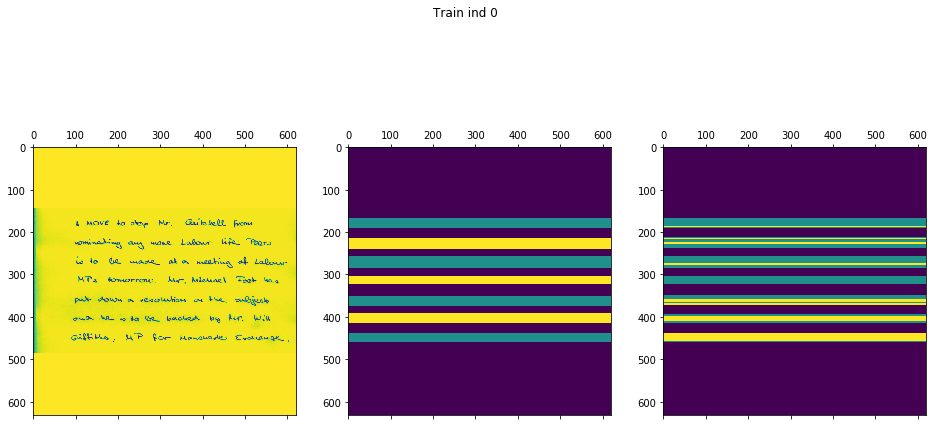

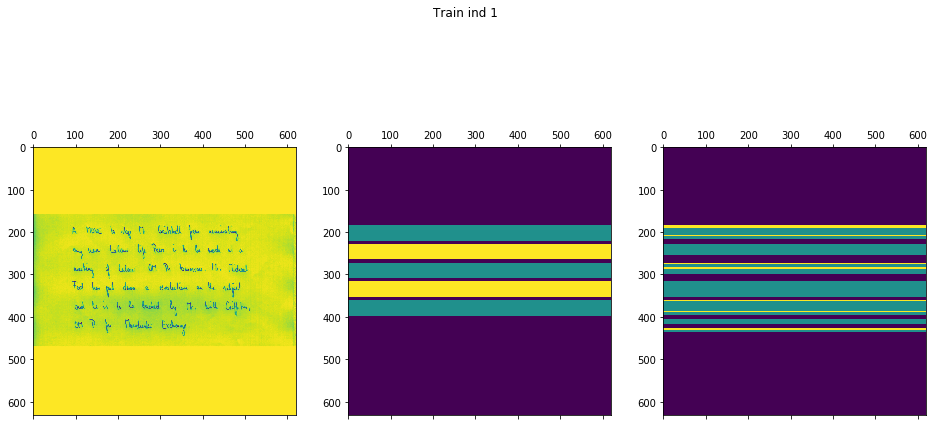

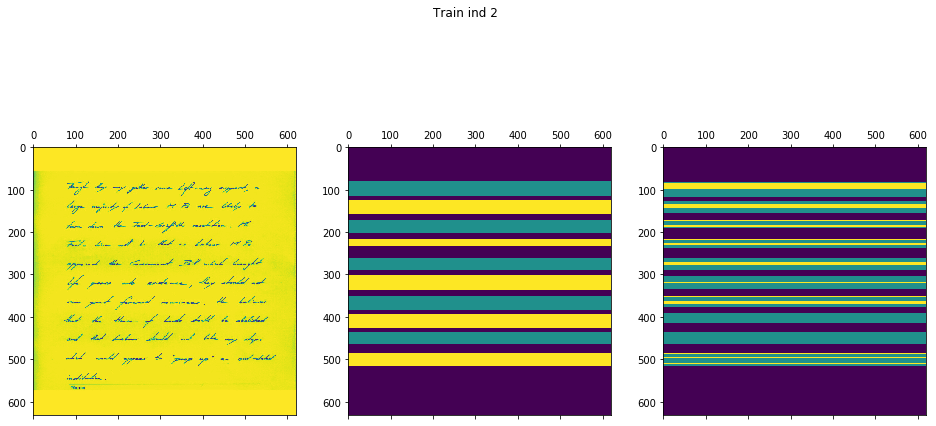

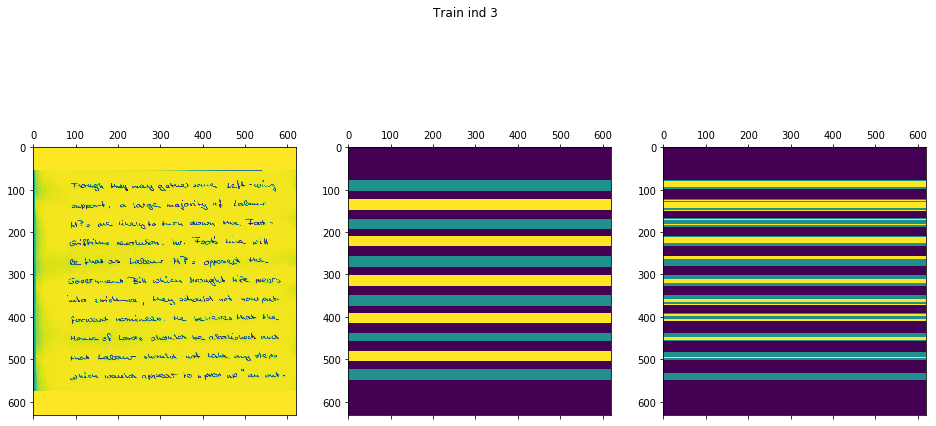

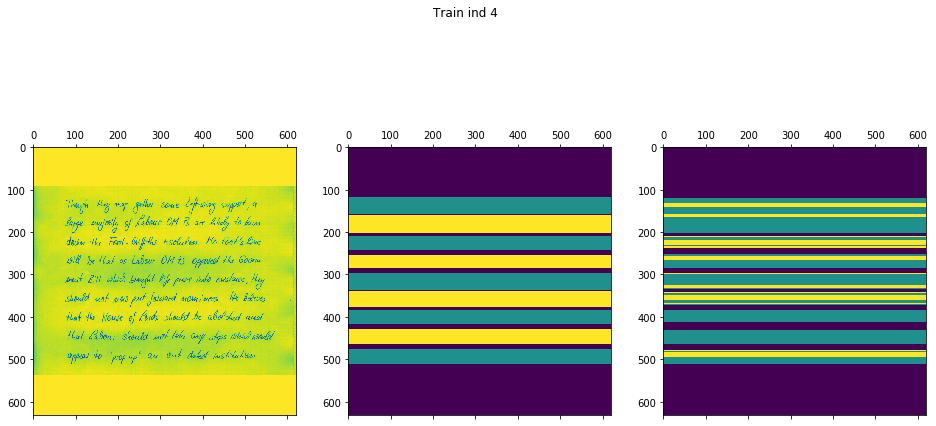

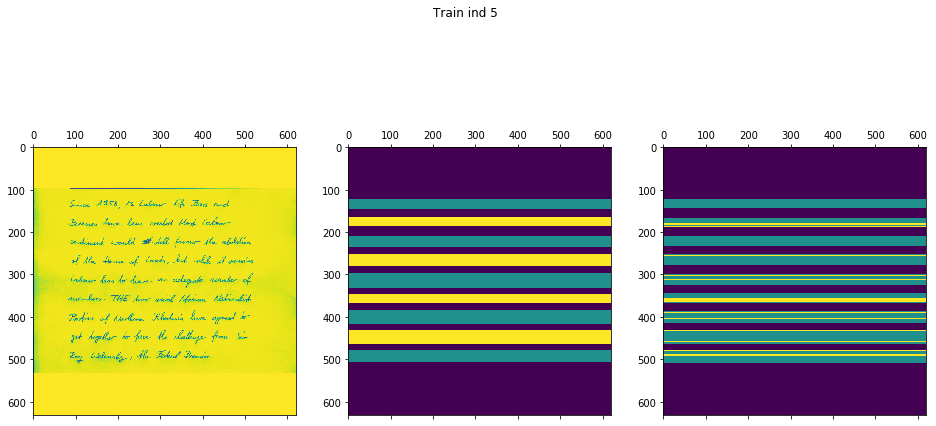

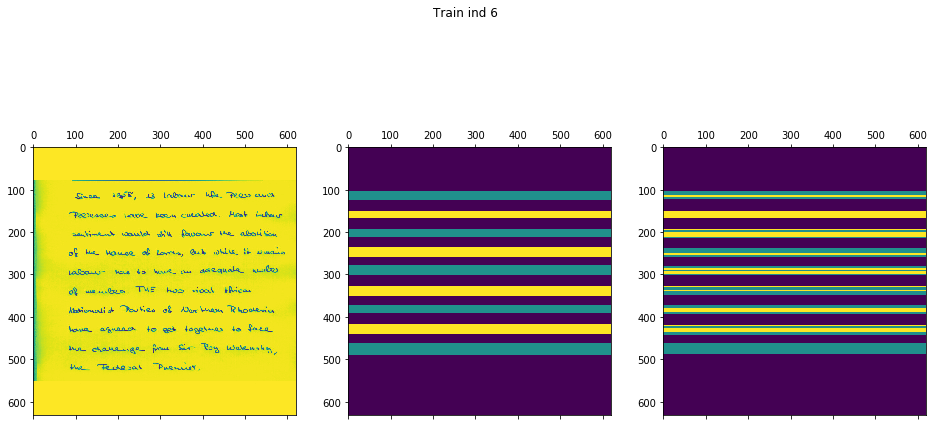

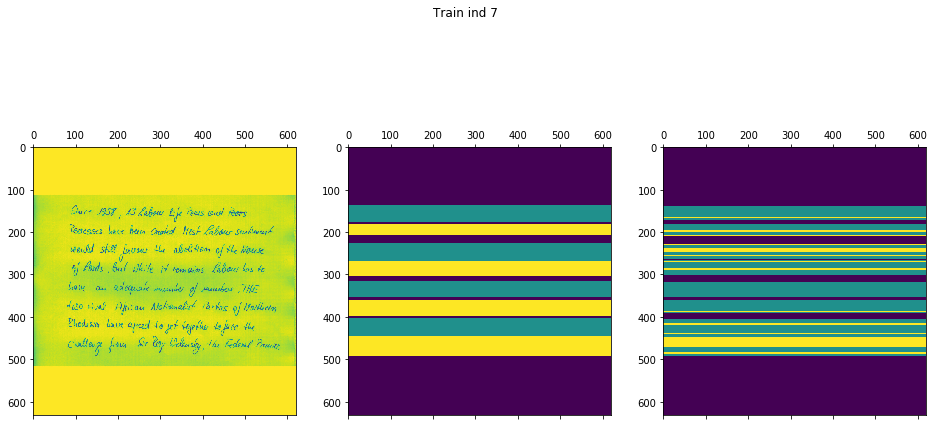

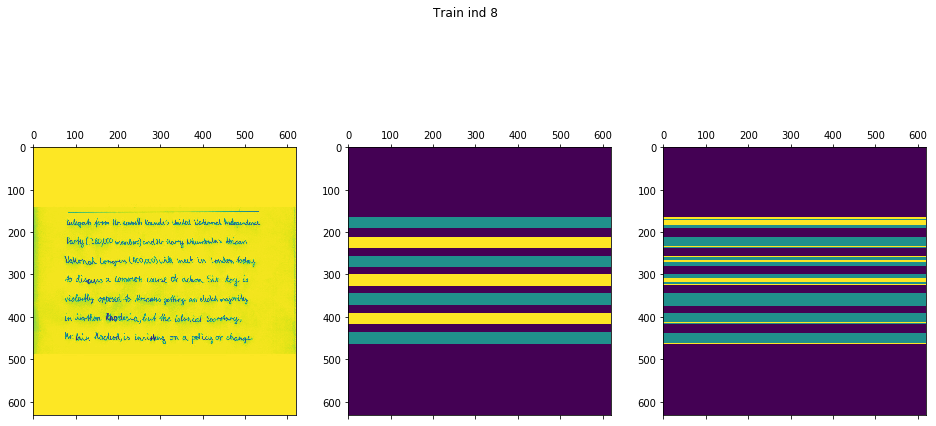

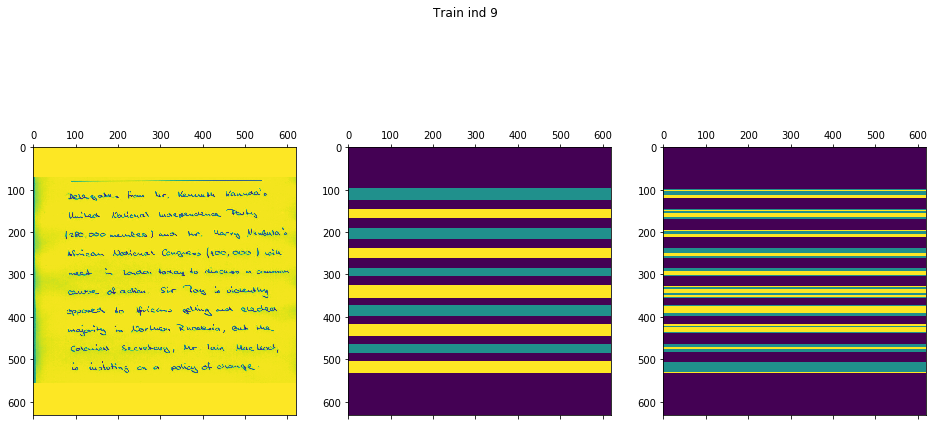

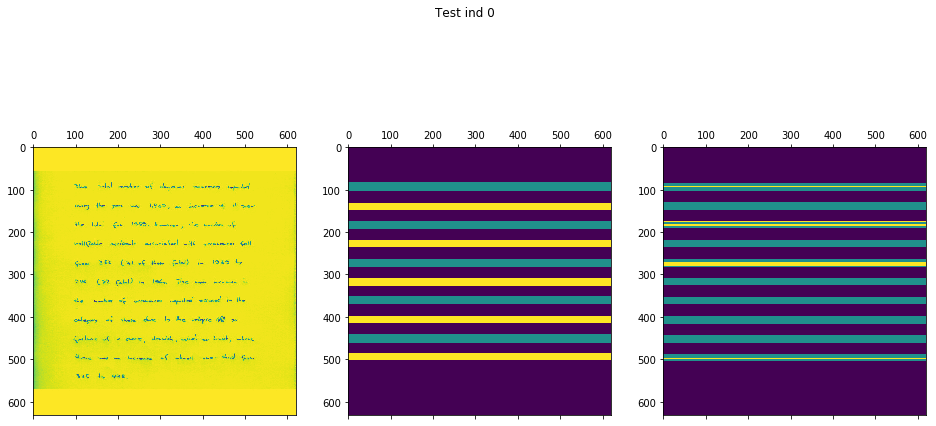

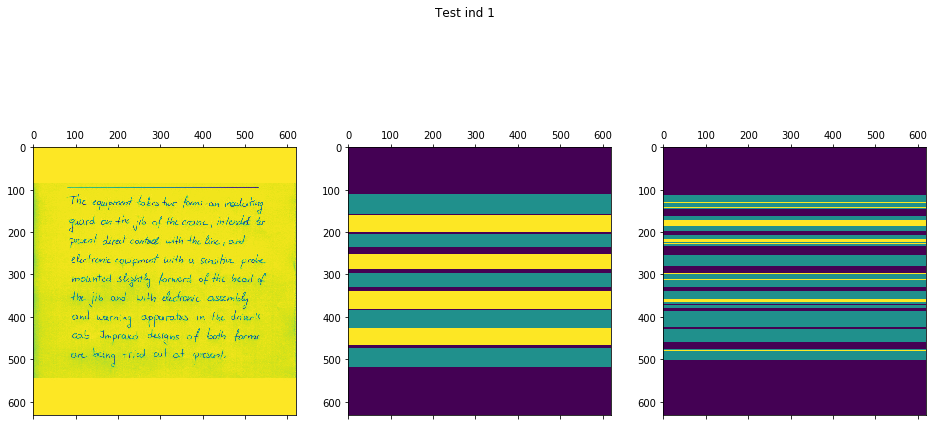

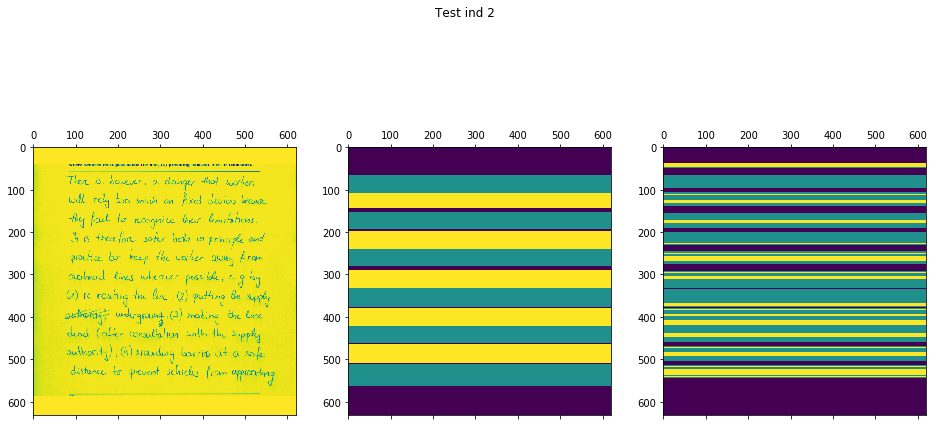

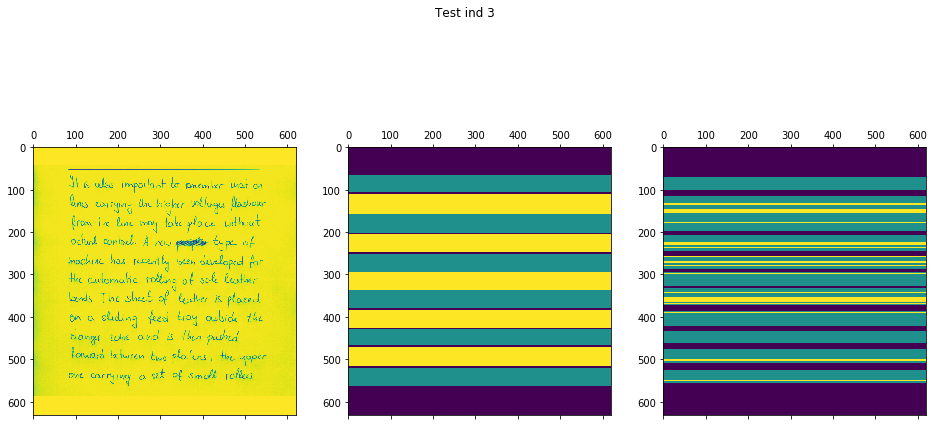

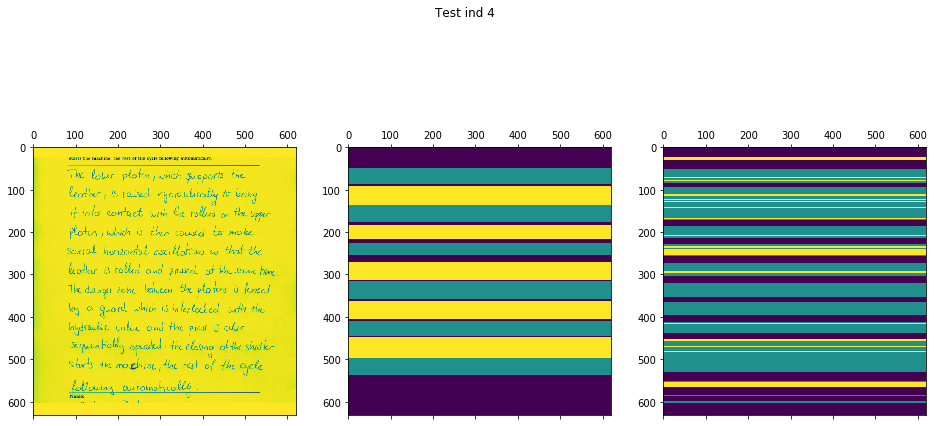

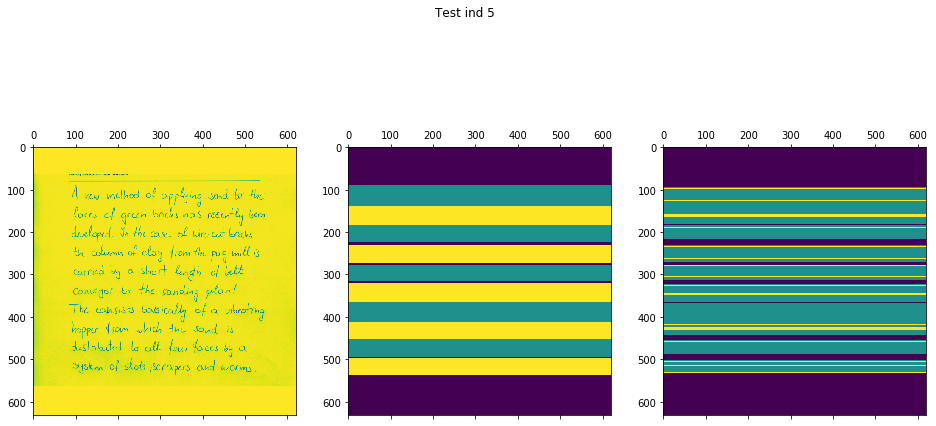

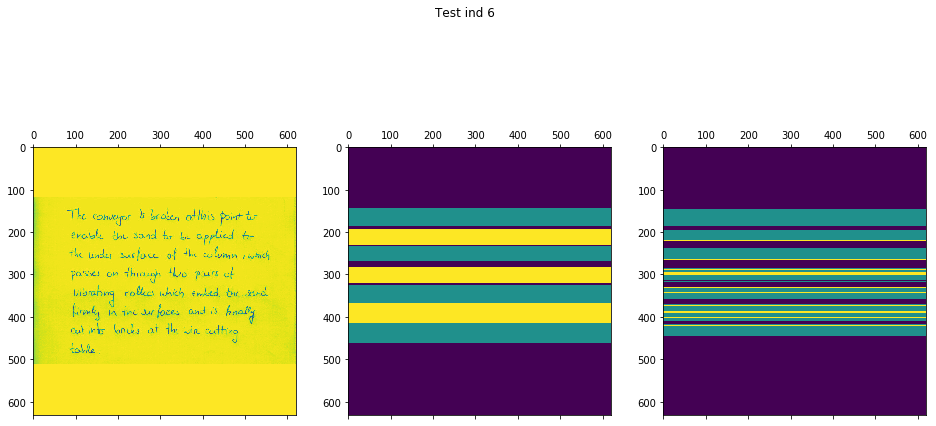

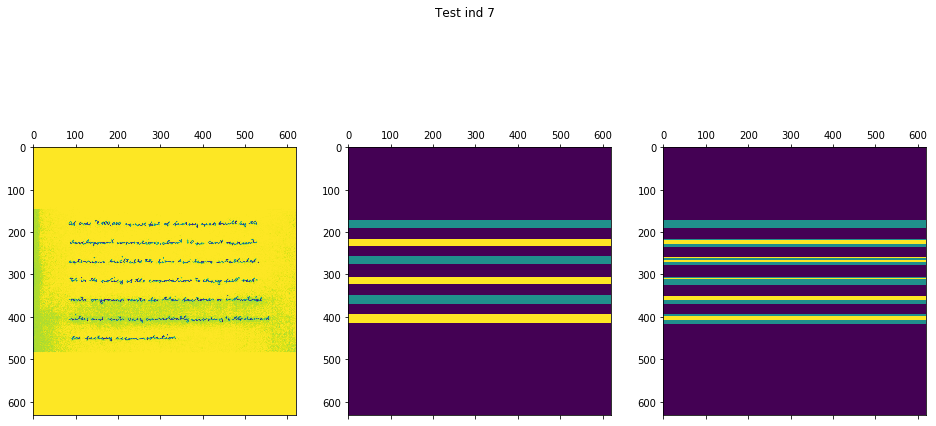

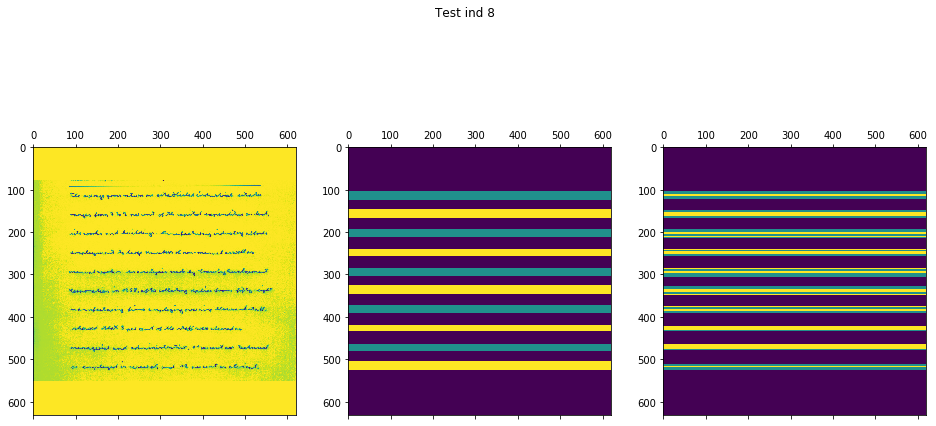

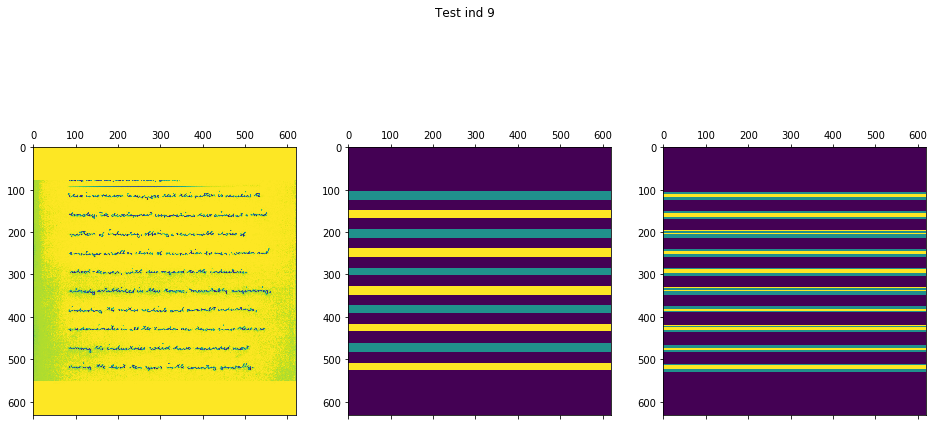

In [116]:
def plot_gt_and_pred(ind, X, Y, preds, title):
    sample_input = np.expand_dims(X[ind], 0)
    gt = Y[ind].argmax(-1)
    pred = preds[ind].argmax(-1)
    fig = plt.figure(figsize=(16, 8))
    fig.suptitle(title)
    ax1 = fig.add_subplot(131)
    ax1.matshow(X[ind].squeeze())
    ax2 = fig.add_subplot(132)
    ax2.matshow(np.repeat(np.expand_dims(gt, -1), MAX_WIDTH, axis=-1))
    ax3 = fig.add_subplot(133)
    ax3.matshow(np.repeat(np.expand_dims(pred, -1), MAX_WIDTH, axis=-1))

preds = model.predict(X[:10])
for ind in range(10):
    plot_gt_and_pred(ind, X, Y, preds, f'Train ind {ind}')
    
preds = model.predict(X_test[:10])
for ind in range(10):
    plot_gt_and_pred(ind, X_test, Y_test, preds, f'Test ind {ind}')